# Machine Learning using PySpark

## Classification

### Binomial logistic regression

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("PySpark logistic regression Binary") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
spark

### load data

In [76]:
path = 'file:///Users/tjmask/Desktop/Semester2/Spark/PySpark/Datasets/eBayAuctions.csv'
df = spark.read.csv(path, header='true',inferSchema='true')

df.show(5)

+----------------+--------+------------+--------+------+----------+---------+------------+
|        Category|currency|sellerRating|Duration|endDay|ClosePrice|OpenPrice|Competitive?|
+----------------+--------+------------+--------+------+----------+---------+------------+
|Music/Movie/Game|      US|        3249|       5|   Mon|      0.01|     0.01|           0|
|Music/Movie/Game|      US|        3249|       5|   Mon|      0.01|     0.01|           0|
|Music/Movie/Game|      US|        3249|       5|   Mon|      0.01|     0.01|           0|
|Music/Movie/Game|      US|        3249|       5|   Mon|      0.01|     0.01|           0|
|Music/Movie/Game|      US|        3249|       5|   Mon|      0.01|     0.01|           0|
+----------------+--------+------------+--------+------+----------+---------+------------+
only showing top 5 rows



In [77]:
## renaming columns
df = df.withColumnRenamed('Competitive?','CompetitiveOrNot')

In [78]:
df.printSchema()

root
 |-- Category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- sellerRating: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- endDay: string (nullable = true)
 |-- ClosePrice: double (nullable = true)
 |-- OpenPrice: double (nullable = true)
 |-- CompetitiveOrNot: integer (nullable = true)



In [79]:
df.describe().show()

+-------+-----------------+--------+-----------------+------------------+------+-----------------+------------------+------------------+
|summary|         Category|currency|     sellerRating|          Duration|endDay|       ClosePrice|         OpenPrice|  CompetitiveOrNot|
+-------+-----------------+--------+-----------------+------------------+------+-----------------+------------------+------------------+
|  count|             1972|    1972|             1972|              1972|  1972|             1972|              1972|              1972|
|   mean|             null|    null|3560.238336713996|  6.48630831643002|  null|36.44908722109523|12.926267748478686|0.5405679513184585|
| stddev|             null|    null|5973.011032512105|2.0529063093178253|  null|89.49385836475687|38.856149207927324|0.4984779288063969|
|    min|Antique/Art/Craft|     EUR|                0|                 1|   Fri|             0.01|              0.01|                 0|
|    max|     Toys/Hobbies|      US|     

### deal with category Variables

In [80]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]
    print(indexers)
    
    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]
    print(encoders)
    
    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")
    print(assembler)
    
    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

In [81]:
catCols = ['Category','currency','endDay']
numCols = ['sellerRating', 'Duration', 'ClosePrice','OpenPrice']
labelCol = 'CompetitiveOrNot'

data = get_dummy(df,catCols,numCols,labelCol)
data.show(5)

[StringIndexer_4b122f9a46fa, StringIndexer_211cca9845d0, StringIndexer_dd17caceee53]
[OneHotEncoder_0389b1681a61, OneHotEncoder_9a069a01a161, OneHotEncoder_7645fdd19567]
VectorAssembler_5690f9a553c2
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[0,17,19,25,2...|    0|
|(29,[0,17,19,25,2...|    0|
|(29,[0,17,19,25,2...|    0|
|(29,[0,17,19,25,2...|    0|
|(29,[0,17,19,25,2...|    0|
+--------------------+-----+
only showing top 5 rows



In [21]:
get_dummy(df,catCols,numCols,labelCol)

[StringIndexer_702641b88d6c, StringIndexer_edb0e829e50f, StringIndexer_11cac07ee129]
[OneHotEncoder_c03e15a42fdf, OneHotEncoder_f99c3a6de417, OneHotEncoder_a9e5f420f061]
VectorAssembler_6d6e997307cd


DataFrame[features: vector, label: int]

In [150]:
data.rdd.take(5)

[Row(features=SparseVector(29, {0: 1.0, 17: 1.0, 19: 1.0, 25: 3249.0, 26: 5.0, 27: 0.01, 28: 0.01}), label=0),
 Row(features=SparseVector(29, {0: 1.0, 17: 1.0, 19: 1.0, 25: 3249.0, 26: 5.0, 27: 0.01, 28: 0.01}), label=0),
 Row(features=SparseVector(29, {0: 1.0, 17: 1.0, 19: 1.0, 25: 3249.0, 26: 5.0, 27: 0.01, 28: 0.01}), label=0),
 Row(features=SparseVector(29, {0: 1.0, 17: 1.0, 19: 1.0, 25: 3249.0, 26: 5.0, 27: 0.01, 28: 0.01}), label=0),
 Row(features=SparseVector(29, {0: 1.0, 17: 1.0, 19: 1.0, 25: 3249.0, 26: 5.0, 27: 0.01, 28: 0.01}), label=0)]

In [85]:
df.select('Category').distinct().show()

+--------------------+
|            Category|
+--------------------+
|         Home/Garden|
| Business/Industrial|
|   Antique/Art/Craft|
|    Music/Movie/Game|
|        Coins/Stamps|
|       Pottery/Glass|
|       SportingGoods|
|         Electronics|
|          Automotive|
|        Toys/Hobbies|
|               Books|
|            Computer|
|      EverythingElse|
|Clothing/Accessories|
|        Collectibles|
|         Photography|
|       Health/Beauty|
|             Jewelry|
+--------------------+



In [22]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+-------------------------------------------------------------+-----+
|features                                                     |label|
+-------------------------------------------------------------+-----+
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,133.0,5.0,22.76,8.99])|1    |
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,841.0,5.0,0.99,0.99]) |0    |
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,841.0,5.0,0.99,0.99]) |0    |
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,841.0,5.0,0.99,0.99]) |0    |
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,841.0,5.0,0.99,0.99]) |1    |
+-------------------------------------------------------------+-----+
only showing top 5 rows

+-------------------------------------------------------------+-----+
|features                                                     |label|
+-------------------------------------------------------------+-----+
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,133.0,5.0,45.44,8.99])|1    |
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,471.0,5.0,9.5,0.99])  |1 

In [23]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='features', labelCol='label')

In [ ]:
# # Convert indexed labels back to original labels.
# labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
#                                labels=labelIndexer.labels)

In [25]:
# Chain indexers and tree in a Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[logr])

In [26]:
model = pipeline.fit(trainingData)

In [27]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(29,[0,17,19,25,2...|    1|[-3.7287406917122...|[0.02345950005208...|       1.0|
|(29,[0,17,19,25,2...|    1|[-1.2875114696054...|[0.21627431824413...|       1.0|
|(29,[0,17,19,25,2...|    0|[-0.5051900452951...|[0.37632176632058...|       1.0|
|(29,[0,17,19,25,2...|    1|[-0.6665028477303...|[0.33928035342635...|       1.0|
|(29,[0,17,19,25,2...|    1|[-0.7764478862616...|[0.31508595235784...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.227217


In [60]:
lrModel = model.stages[0]
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
maxFMeasure
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|0.037037037037037035|
|0.003787878787878788| 0.04830917874396135|
|0.003787878787878788| 0.06280193236714976|
|0.003787878787878788| 0.07729468599033816|
+--------------------+--------------------+
only showing top 5 rows

areaUnderROC: 0.8563991362904404


[Row(max(F-Measure)=0.7939053728949479)]

In [33]:
roc_data = trainingSummary.roc
roc_data.count()

109

### zeppelin

In [52]:
import seaborn as sns
x = roc_data[['FPR']].toPandas()['FPR']
y = roc_data[['TPR']].toPandas()['TPR']

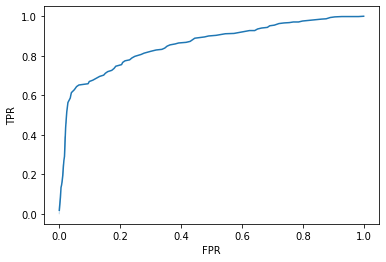

In [53]:
sns.lineplot(x=x, y=y)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [72]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_temp

class_names = map(str, class_temp)
class_names

In [82]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[1,0])
cnf_matrix

array([[343, 102],
       [ 85, 293]])

Confusion matrix, without normalization
[[343 102]
 [ 85 293]]


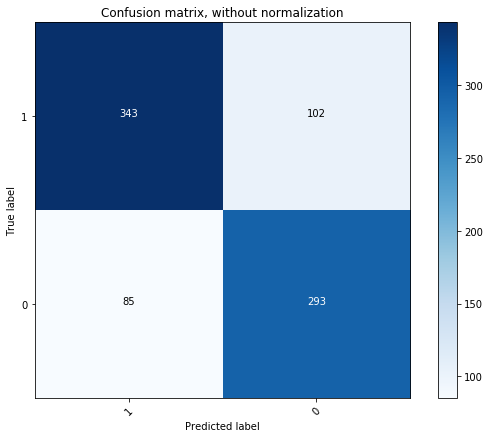

In [83]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['1','0'],
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.77078652 0.22921348]
 [0.22486772 0.77513228]]


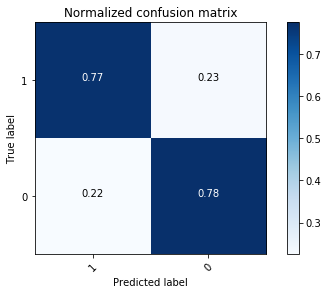

In [85]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','0'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Multinomial logistic regression

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder \
    .appName("PySpark Multinomial logistic regression") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
spark

In [108]:
path = 'file:///Users/tjmask/Desktop/Semester2/Spark/PySpark/Datasets/winequality-red.csv'

df = spark.read.csv(path, header='true', inferSchema='true')
df.show(5)

+------------+---------------+----------+-------------+---------+-----------------+------------------+-------+----+---------+-------+-------+
|fixedAcidity|volatileAcidity|citricAcid|residualSugar|chlorides|freeSulfurDioxide|totalSulfurDioxide|density|  pH|sulphates|alcohol|quality|
+------------+---------------+----------+-------------+---------+-----------------+------------------+-------+----+---------+-------+-------+
|         7.4|            0.7|       0.0|          1.9|    0.076|             11.0|              34.0| 0.9978|3.51|     0.56|    9.4|      5|
|         7.8|           0.88|       0.0|          2.6|    0.098|             25.0|              67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|         7.8|           0.76|      0.04|          2.3|    0.092|             15.0|              54.0|  0.997|3.26|     0.65|    9.8|      5|
|        11.2|           0.28|      0.56|          1.9|    0.075|             17.0|              60.0|  0.998|3.16|     0.58|    9.8|      6|
|     

In [109]:
df.printSchema()

root
 |-- fixedAcidity: double (nullable = true)
 |-- volatileAcidity: double (nullable = true)
 |-- citricAcid: double (nullable = true)
 |-- residualSugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- freeSulfurDioxide: double (nullable = true)
 |-- totalSulfurDioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [110]:
### understand udf

In [111]:
from pyspark.sql.types import IntegerType
slen = udf(lambda s: len(s), IntegerType())

def to_upper(s):
    if s is not None:
        return s.upper()
to_upper_udf = udf(to_upper, returnType=StringType())
    
def add_one(x):
    if x is not None:
        return x + 1
    
add_one_udf = udf(add_one, returnType=IntegerType())
    
# df = spark.createDataFrame([(1, "John Doe", 21)], ("id", "name", "age"))
# df.select(slen("name").alias("slen(name)"), to_upper("name"), add_one_udf("age")).show()

In [112]:
# Convert to float format
def string_to_float(x):
    return float(x)

#
def condition(r):
    if (0<= r <= 4):
        label = "low"
    elif(4< r <= 6):
        label = "medium"
    else:
        label = "high"
    return label

In [113]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x: condition(x), StringType())

df = df.withColumn("quality", quality_udf("quality"))

df.show(5,True)

+------------+---------------+----------+-------------+---------+-----------------+------------------+-------+----+---------+-------+-------+
|fixedAcidity|volatileAcidity|citricAcid|residualSugar|chlorides|freeSulfurDioxide|totalSulfurDioxide|density|  pH|sulphates|alcohol|quality|
+------------+---------------+----------+-------------+---------+-----------------+------------------+-------+----+---------+-------+-------+
|         7.4|            0.7|       0.0|          1.9|    0.076|             11.0|              34.0| 0.9978|3.51|     0.56|    9.4| medium|
|         7.8|           0.88|       0.0|          2.6|    0.098|             25.0|              67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|         7.8|           0.76|      0.04|          2.3|    0.092|             15.0|              54.0|  0.997|3.26|     0.65|    9.8| medium|
|        11.2|           0.28|      0.56|          1.9|    0.075|             17.0|              60.0|  0.998|3.16|     0.58|    9.8| medium|
|     

In [114]:
df.printSchema()

root
 |-- fixedAcidity: double (nullable = true)
 |-- volatileAcidity: double (nullable = true)
 |-- citricAcid: double (nullable = true)
 |-- residualSugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- freeSulfurDioxide: double (nullable = true)
 |-- totalSulfurDioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: string (nullable = true)



In [115]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))
    
    return data.select('features','label')

In [116]:
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [117]:
transformed = transData(df)
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



In [118]:
transformed.rdd.take(1)

[Row(features=DenseVector([7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]), label='medium')]

In [122]:
m = [(Vectors.sparse(5, [(1, 1.0), (3, 7.0)]),),
        (Vectors.dense([2.0, 0.0, 3.0, 4.0, 5.0]),),
        (Vectors.dense([4.0, 0.0, 0.0, 6.0, 7.0]),)]
m

[(SparseVector(5, {1: 1.0, 3: 7.0}),),
 (DenseVector([2.0, 0.0, 3.0, 4.0, 5.0]),),
 (DenseVector([4.0, 0.0, 0.0, 6.0, 7.0]),)]

In [125]:
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
+--------------------+------+------------+
only showing top 5 rows



In [43]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features| label|     indexedFeatures|
+--------------------+------+--------------------+
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|medium|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|medium|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|medium|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
+--------------------+------+--------------------+
only showing top 5 rows



In [45]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+---------------------------------------------------------+------+
|features                                                 |label |
+---------------------------------------------------------+------+
|[4.7,0.6,0.17,2.3,0.058,17.0,106.0,0.9932,3.85,0.6,12.9] |medium|
|[4.9,0.42,0.0,2.1,0.048,16.0,42.0,0.99154,3.71,0.74,14.0]|high  |
|[5.0,0.38,0.01,1.6,0.048,26.0,60.0,0.99084,3.7,0.75,14.0]|medium|
|[5.0,0.4,0.5,4.3,0.046,29.0,80.0,0.9902,3.49,0.66,13.6]  |medium|
|[5.0,0.42,0.24,2.0,0.06,19.0,50.0,0.9917,3.72,0.74,14.0] |high  |
+---------------------------------------------------------+------+
only showing top 5 rows

+----------------------------------------------------------+------+
|features                                                  |label |
+----------------------------------------------------------+------+
|[4.6,0.52,0.15,2.1,0.054,8.0,65.0,0.9934,3.9,0.56,13.1]   |low   |
|[5.0,0.74,0.0,1.2,0.041,16.0,46.0,0.99258,4.01,0.59,12.5] |medium|
|[5.0,1.04,0.24,1.6,0.05,32.0,96

In [47]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])


# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [48]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.6,0.52,0.15,2....|   low|        medium|
|[5.0,0.74,0.0,1.2...|medium|        medium|
|[5.0,1.04,0.24,1....|medium|        medium|
|[5.1,0.47,0.02,1....|medium|        medium|
|[5.1,0.51,0.18,2....|  high|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [126]:
predictions.show(2)

+--------------------+------+------------+--------------------+--------------------+--------------------+----------+--------------+
|            features| label|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|predictedLabel|
+--------------------+------+------------+--------------------+--------------------+--------------------+----------+--------------+
|[4.6,0.52,0.15,2....|   low|         2.0|[4.6,0.52,0.15,2....|[1.14104803021670...|[0.62969966103623...|       0.0|        medium|
|[5.0,0.74,0.0,1.2...|medium|         0.0|[5.0,0.74,0.0,1.2...|[1.17188495818702...|[0.74342710613184...|       0.0|        medium|
+--------------------+------+------------+--------------------+--------------------+--------------------+----------+--------------+
only showing top 2 rows



In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.152027


In [134]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary
lrModel.params

[Param(parent='LogisticRegression_a84e570af184', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'),
 Param(parent='LogisticRegression_a84e570af184', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'),
 Param(parent='LogisticRegression_a84e570af184', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'),
 Param(parent='LogisticRegression_a84e570af184', name='featuresCol', doc='features column name'),
 Param(parent='LogisticRegression_a84e570af184', name='fitIntercept', doc='whether to fit an intercept term'),
 Param(parent='LogisticRegression_a84e570af184', name='labelCol', doc='label column name'),
 Param(parent='LogisticRegression_a84e570af184', name='lowerBoundsOnCoefficients', doc='The lower bounds on coefficients if fitting under bound constrai

In [139]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

AttributeError: 'LogisticRegressionTrainingSummary' object has no attribute 'roc'

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [60]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
# class_names = map(str, class_temp)
# # # # print(class_name)
# class_names

In [65]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_temp)
cnf_matrix

array([[482,  14,   2],
       [ 48,  19,   0],
       [ 25,   1,   1]])

In [64]:
class_temp

['medium', 'high', 'low']

Confusion matrix, without normalization
[[482  14   2]
 [ 48  19   0]
 [ 25   1   1]]


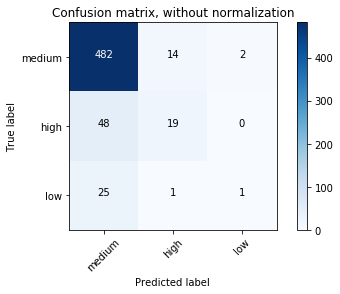

In [67]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.96787149 0.02811245 0.00401606]
 [0.71641791 0.28358209 0.        ]
 [0.92592593 0.03703704 0.03703704]]


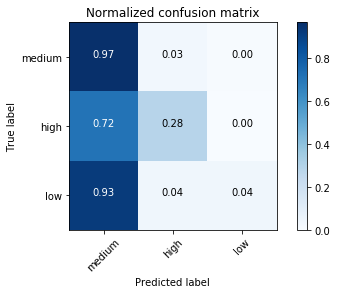

In [69]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## decision tree

In [140]:
path = 'file:///Users/tjmask/Desktop/Semester2/Spark/PySpark/Datasets/winequality-red.csv'

df = spark.read.csv(path, header='true', inferSchema='true')
df.show(5)

+------------+---------------+----------+-------------+---------+-----------------+------------------+-------+----+---------+-------+-------+
|fixedAcidity|volatileAcidity|citricAcid|residualSugar|chlorides|freeSulfurDioxide|totalSulfurDioxide|density|  pH|sulphates|alcohol|quality|
+------------+---------------+----------+-------------+---------+-----------------+------------------+-------+----+---------+-------+-------+
|         7.4|            0.7|       0.0|          1.9|    0.076|             11.0|              34.0| 0.9978|3.51|     0.56|    9.4|      5|
|         7.8|           0.88|       0.0|          2.6|    0.098|             25.0|              67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|         7.8|           0.76|      0.04|          2.3|    0.092|             15.0|              54.0|  0.997|3.26|     0.65|    9.8|      5|
|        11.2|           0.28|      0.56|          1.9|    0.075|             17.0|              60.0|  0.998|3.16|     0.58|    9.8|      6|
|     

In [141]:
# Convert to float format
def string_to_float(x):
    return float(x)

#
def condition(r):
    if (0<= r <= 4):
        label = "low"
    elif(4< r <= 6):
        label = "medium"
    else:
        label = "high"
    return label

In [142]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x: condition(x), StringType())

In [143]:
df = df.withColumn("quality", quality_udf("quality"))
df.show(5,True)
df.printSchema()

+------------+---------------+----------+-------------+---------+-----------------+------------------+-------+----+---------+-------+-------+
|fixedAcidity|volatileAcidity|citricAcid|residualSugar|chlorides|freeSulfurDioxide|totalSulfurDioxide|density|  pH|sulphates|alcohol|quality|
+------------+---------------+----------+-------------+---------+-----------------+------------------+-------+----+---------+-------+-------+
|         7.4|            0.7|       0.0|          1.9|    0.076|             11.0|              34.0| 0.9978|3.51|     0.56|    9.4| medium|
|         7.8|           0.88|       0.0|          2.6|    0.098|             25.0|              67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|         7.8|           0.76|      0.04|          2.3|    0.092|             15.0|              54.0|  0.997|3.26|     0.65|    9.8| medium|
|        11.2|           0.28|      0.56|          1.9|    0.075|             17.0|              60.0|  0.998|3.16|     0.58|    9.8| medium|
|     

In [151]:
# !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [152]:
def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [153]:
transformed = transData(df)
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



In [154]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
+--------------------+------+------------+
only showing top 5 rows



In [156]:
labelIndexer.labels

['medium', 'high', 'low']

In [160]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features| label|     indexedFeatures|
+--------------------+------+--------------------+
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|medium|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|medium|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|medium|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
+--------------------+------+--------------------+
only showing top 5 rows



In [157]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])

trainingData.show(5)
testData.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[4.6,0.52,0.15,2....|   low|
|[4.7,0.6,0.17,2.3...|medium|
|[4.9,0.42,0.0,2.1...|  high|
|[5.0,0.38,0.01,1....|medium|
|[5.0,0.74,0.0,1.2...|medium|
+--------------------+------+
only showing top 5 rows

+--------------------+------+
|            features| label|
+--------------------+------+
|[5.0,0.4,0.5,4.3,...|medium|
|[5.0,0.42,0.24,2....|  high|
|[5.1,0.585,0.0,1....|  high|
|[5.2,0.32,0.25,1....|medium|
|[5.2,0.34,0.0,1.8...|medium|
+--------------------+------+
only showing top 5 rows



In [163]:
from pyspark.ml.classification import DecisionTreeClassifier

# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [164]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [165]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree,labelConverter])

In [166]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [167]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[5.0,0.4,0.5,4.3,...|medium|        medium|
|[5.0,0.42,0.24,2....|  high|        medium|
|[5.1,0.585,0.0,1....|  high|          high|
|[5.2,0.32,0.25,1....|medium|        medium|
|[5.2,0.34,0.0,1.8...|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [170]:
predictions.show(2)

+--------------------+------+------------+--------------------+--------------+--------------------+----------+--------------+
|            features| label|indexedLabel|     indexedFeatures| rawPrediction|         probability|prediction|predictedLabel|
+--------------------+------+------------+--------------------+--------------+--------------------+----------+--------------+
|[5.0,0.4,0.5,4.3,...|medium|         0.0|[5.0,0.4,0.5,4.3,...|[56.0,4.0,1.0]|[0.91803278688524...|       0.0|        medium|
|[5.0,0.42,0.24,2....|  high|         1.0|[5.0,0.42,0.24,2....| [8.0,1.0,0.0]|[0.88888888888888...|       0.0|        medium|
+--------------------+------+------------+--------------------+--------------+--------------------+----------+--------------+
only showing top 2 rows



In [168]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.16195
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_96cce20f199c) of depth 5 with 39 nodes


## random forest

In [171]:
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

In [172]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [173]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

In [174]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [175]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[5.0,0.4,0.5,4.3,...|medium|        medium|
|[5.0,0.42,0.24,2....|  high|          high|
|[5.1,0.585,0.0,1....|  high|          high|
|[5.2,0.32,0.25,1....|medium|        medium|
|[5.2,0.34,0.0,1.8...|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [178]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.150943
RandomForestClassificationModel (uid=RandomForestClassifier_b2ec14e71140) with 10 trees


## gradient boosting

In [183]:
from pysparkling import *
import h2o
hc = H2OContext.getOrCreate(spark)

NameError: name 'H2OContext' is not defined

## Naive Bayes Classification

In [184]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(featuresCol='indexedFeatures', labelCol='indexedLabel')

In [185]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [186]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, nb,labelConverter])

In [187]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [188]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[5.0,0.4,0.5,4.3,...|medium|        medium|
|[5.0,0.42,0.24,2....|  high|        medium|
|[5.1,0.585,0.0,1....|  high|        medium|
|[5.2,0.32,0.25,1....|medium|        medium|
|[5.2,0.34,0.0,1.8...|medium|        medium|
+--------------------+------+--------------+
only showing top 5 rows



In [189]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.341195


In [190]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary
trainingSummary.roc.show()

AttributeError: 'NaiveBayesModel' object has no attribute 'summary'